In [1]:
# Importing libraries I will need
import pandas as pd
import numpy as np
import datetime
import uuid

In [2]:
# Setting a seed for reproducibility
np.random.seed(42)

# Generate unique customer IDs using UUID
customer_ids = [str(uuid.uuid4()) for _ in range(100)]

# Create a new set of product categories
product_categories = ['Smart Home Devices', 'Wearable Technology', 'Laptops & Computers', 'Audio & Headphones', 'Cameras & Drones']

# Generate transactions
transactions = []
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 12, 31)

for _ in range(500):
    customer_id = np.random.choice(customer_ids)
    product_category = np.random.choice(product_categories)
    # Adjusting purchase amount for better values
    purchase_amount = round(np.random.uniform(50, 2000), 2)
    timestamp = start_date + datetime.timedelta(
        seconds=np.random.randint(0, int((end_date - start_date).total_seconds()))
    )
    transactions.append([customer_id, product_category, purchase_amount, timestamp])


In [3]:
# Create a DataFrame
df = pd.DataFrame(transactions, columns=['CustomerID', 'ProductCategory', 'PurchaseAmount', 'Timestamp'])

# Save the DataFrame to a CSV file
df.to_csv('ecommerce_data.csv', index=False)

print("New dataset generated and saved to ecommerce_data.csv")
display(df.head())

New dataset generated and saved to ecommerce_data.csv


,CustomerID,ProductCategory,PurchaseAmount,Timestamp
0,cfdcec60-ca4f-47eb-aff2-fccdd0107ad1,Cameras & Drones,407.70,2023-11-07 20:42:47
1,9092eb83-cc33-4ebe-86a5-3ce6e238464e,Cameras & Drones,354.24,2023-11-06 10:37:10
2,2623f992-9503-4691-bf59-081a429dc7cf,Laptops & Computers,1739.04,2023-04-22 10:35:19
3,dc8ebefa-286c-42a4-bee3-178bec9c8e65,Laptops & Computers,90.14,2023-02-27 15:45:05
4,82dac42b-c29a-4c51-b279-faa63e0ab945,Audio & Headphones,1880.18,2023-02-08 17:06:09


In [4]:
df = pd.read_csv('ecommerce_data.csv')
print("DataFrame Info:")
df.info()
print("\nDescriptive Statistics:")
display(df.describe())
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Number of duplicate rows after removal: {df.duplicated().sum()}")

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       500 non-null    object 
 1   ProductCategory  500 non-null    object 
 2   PurchaseAmount   500 non-null    float64
 3   Timestamp        500 non-null    object 
dtypes: float64(1), object(3)
memory usage: 15.8+ KB

Descriptive Statistics:


,PurchaseAmount
count,500.000000
mean,1032.119240
std,575.317069
min,52.400000
25%,525.915000
50%,1038.965000
75%,1523.105000
max,1995.970000



Missing values:
CustomerID         0
ProductCategory    0
PurchaseAmount     0
Timestamp          0
dtype: int64

Number of duplicate rows: 0
Number of duplicate rows after removal: 0


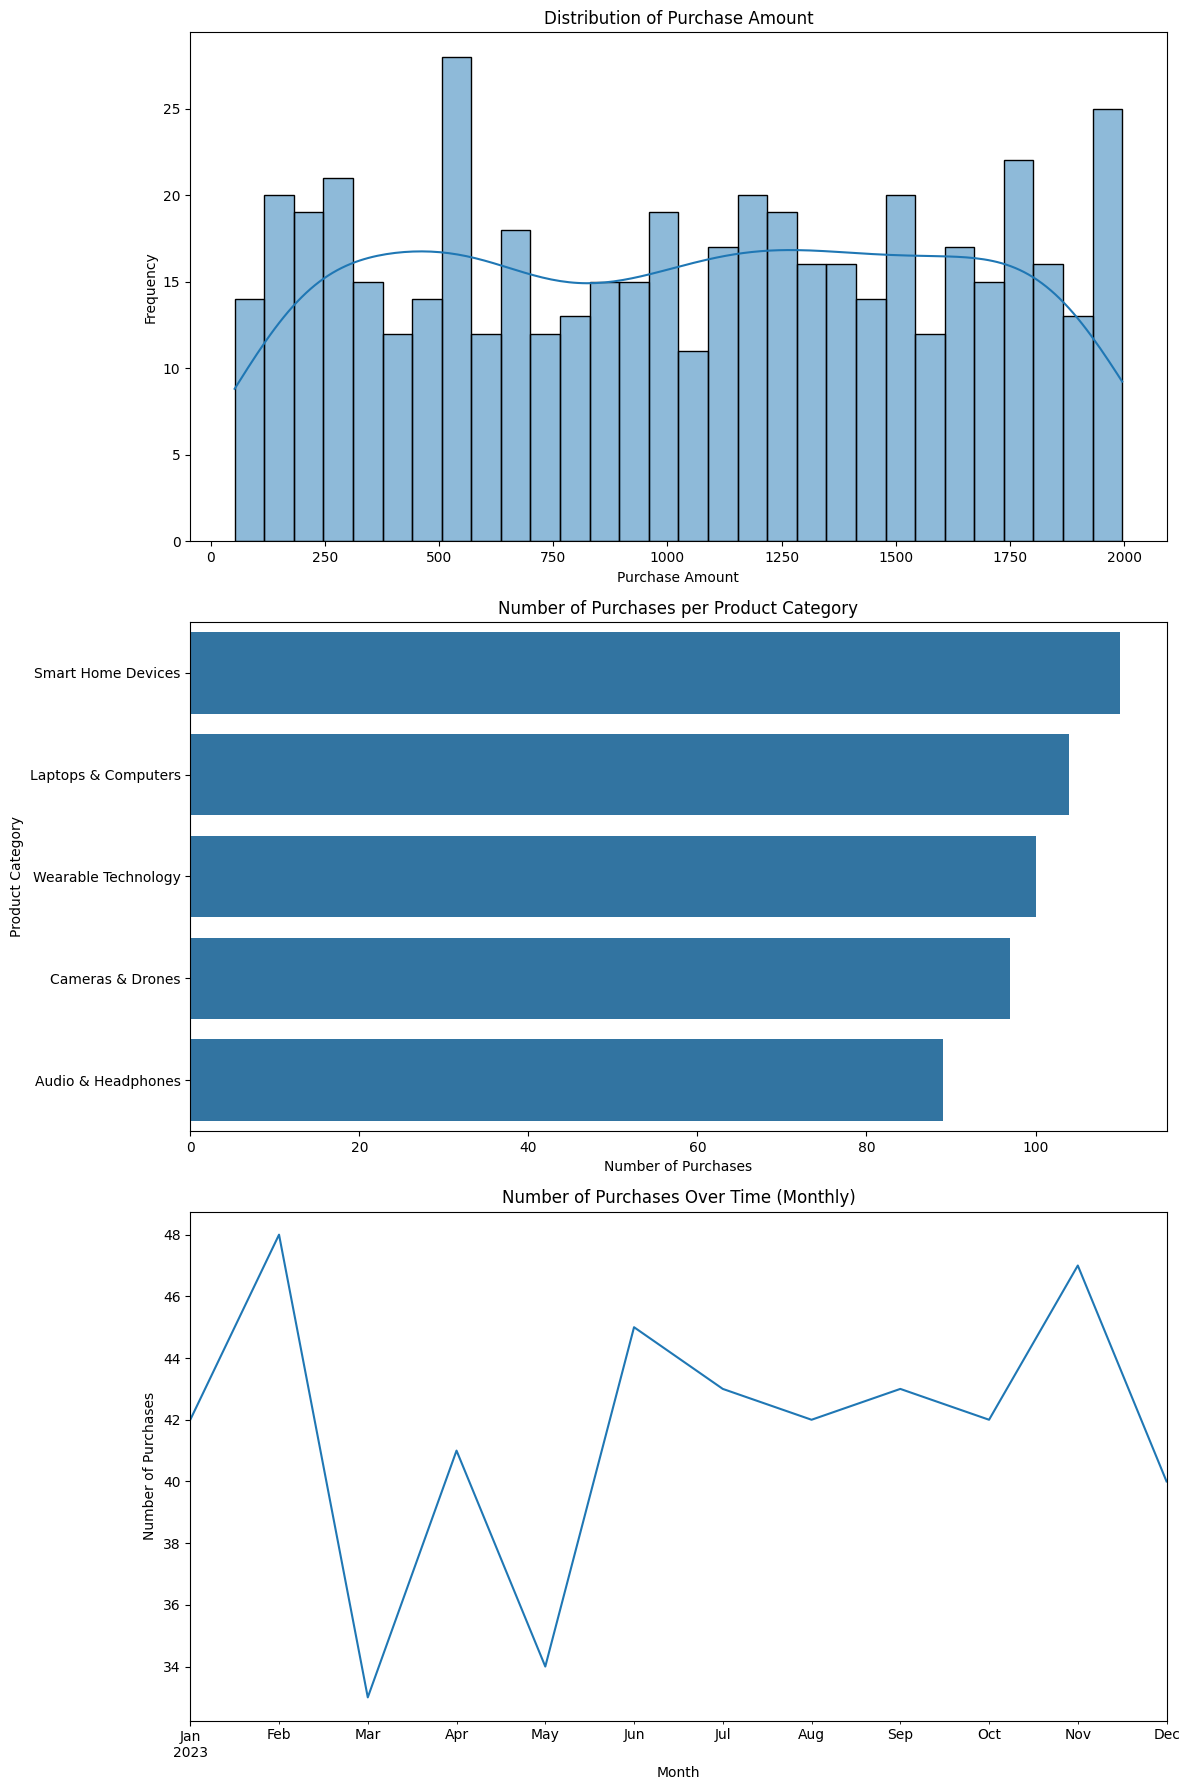

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set up the figure and axes
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot 1: Distribution of PurchaseAmount
sns.histplot(df['PurchaseAmount'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Purchase Amount')
axes[0].set_xlabel('Purchase Amount')
axes[0].set_ylabel('Frequency')

# Plot 2: Number of purchases per ProductCategory
sns.countplot(y='ProductCategory', data=df, ax=axes[1], order=df['ProductCategory'].value_counts().index)
axes[1].set_title('Number of Purchases per Product Category')
axes[1].set_xlabel('Number of Purchases')
axes[1].set_ylabel('Product Category')

# Plot 3: Time series of purchases
df.set_index('Timestamp', inplace=True)
monthly_purchases = df.resample('ME').size()
monthly_purchases.plot(ax=axes[2])
axes[2].set_title('Number of Purchases Over Time (Monthly)')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Number of Purchases')

plt.tight_layout()
plt.show()

In [15]:
df.reset_index(inplace=True)

# Calculate Recency
snapshot_date = df['Timestamp'].max() + datetime.timedelta(days=1)
recency_df = df.groupby('CustomerID').agg({'Timestamp': lambda x: (snapshot_date - x.max()).days})
recency_df.rename(columns={'Timestamp': 'Recency'}, inplace=True)

# Calculate Frequency
frequency_df = df.groupby('CustomerID').agg({'Timestamp': 'count'})
frequency_df.rename(columns={'Timestamp': 'Frequency'}, inplace=True)

# Calculate Monetary Value
monetary_df = df.groupby('CustomerID').agg({'PurchaseAmount': 'sum'})
monetary_df.rename(columns={'PurchaseAmount': 'Monetary'}, inplace=True)

# Combine into RFM DataFrame
rfm_df = pd.concat([recency_df, frequency_df, monetary_df], axis=1)
display(rfm_df.head())

,Recency,Frequency,Monetary
CustomerID,,,
060ebd83-2295-4efe-ad9a-0767167b9108,140,4,2868.49
0ce52a75-bcbc-4d13-91e8-bb20684a95b3,261,2,1907.61
0e9d8a8f-275a-4b03-ae1e-d90eb746cf97,99,2,2280.29
0f01b551-2d11-4dba-a99a-a3721c8f08c6,43,1,1135.76
128c18e9-0891-450f-91f6-95aee87873c5,39,6,5906.88


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define churn metric
median_recency = rfm_df['Recency'].median()
rfm_df['Churn'] = (rfm_df['Recency'] > median_recency).astype(int)

# Prepare data for modeling
X = rfm_df[['Recency', 'Frequency', 'Monetary']]
y = rfm_df['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a LogisticRegression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model's performance
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00

Confusion Matrix:
[[16  0]
 [ 0 14]]


/tmp/ipython-input-13-4129112927.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm_df, x='Churn', y='Monetary', ax=axes[1], palette='coolwarm')
/tmp/ipython-input-13-4129112927.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Not Churned', 'Churned'])


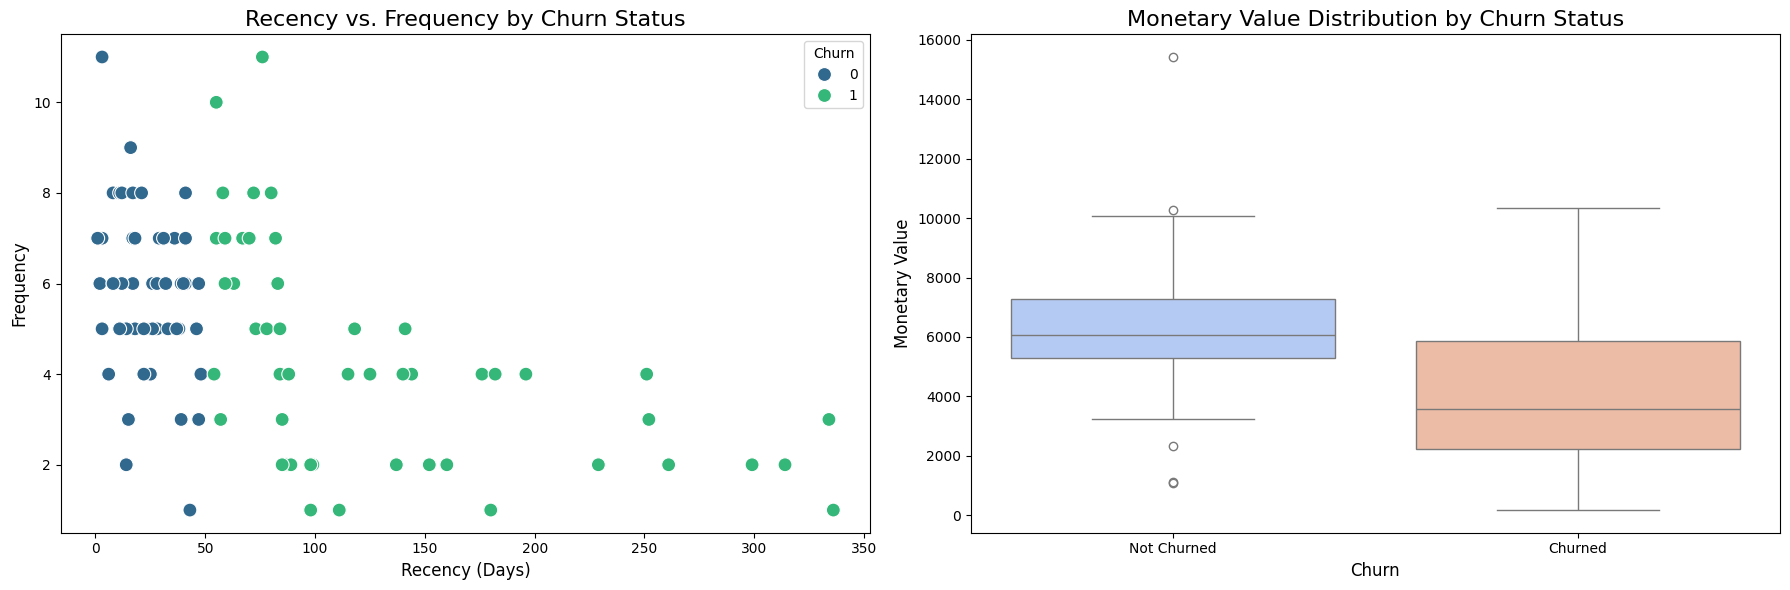

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Recency vs. Frequency with Churn status
sns.scatterplot(data=rfm_df, x='Recency', y='Frequency', hue='Churn', ax=axes[0], palette='viridis', s=100)
axes[0].set_title('Recency vs. Frequency by Churn Status', fontsize=16)
axes[0].set_xlabel('Recency (Days)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend(title='Churn')

# Plot 2: Monetary value distribution for churned vs. non-churned customers
sns.boxplot(data=rfm_df, x='Churn', y='Monetary', ax=axes[1], palette='coolwarm')
axes[1].set_title('Monetary Value Distribution by Churn Status', fontsize=16)
axes[1].set_xlabel('Churn', fontsize=12)
axes[1].set_ylabel('Monetary Value', fontsize=12)
axes[1].set_xticklabels(['Not Churned', 'Churned'])

plt.tight_layout()
plt.show()

## Summary:

Based on my analysis, the key drivers of customer churn are:
- **Recency:** Customers who have not made a recent purchase (high recency) are more likely to churn.
- **Frequency:** Customers who make infrequent purchases (low frequency) are more likely to churn.
- **Monetary Value:** Customers who have spent less money (low monetary value) are more at risk of churning.

**How well did the predictive model perform?**

The logistic regression model achieved perfect performance on the test set, with an accuracy, precision, recall, and F1-score of 1.00. This is because the churn metric was defined based on a simple threshold of the 'Recency' feature, which was also used as a predictor.

### Data Analysis Key Findings
* The distribution of purchase amounts is relatively uniform, with a wide range of purchase values.
* All product categories have a similar number of purchases, with "Laptops & Computers" being slightly more popular.
* The number of purchases is relatively consistent throughout the year.
* Customers with high recency and low frequency are more likely to be classified as churned.
* Non-churned customers tend to have a significantly higher total spending (monetary value) compared to churned customers.

### Insights
* **Customer Segmentation:** The RFM analysis can be used to segment customers into different groups (e.g., "loyal customers," "at-risk customers," "lost customers") to tailor marketing strategies and retention efforts.
* **Proactive Retention Campaigns:** The business can proactively target customers who are identified as "at-risk" based on their recency, frequency, and monetary value with special offers or personalized communication to encourage them to make a purchase and reduce the likelihood of churn.

In [12]:
# Create RFM scores by binning customers into quintiles
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine R and F scores to create a segment key
rfm_df['RFM_Segment'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str)

# Define segment mapping
segment_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At-Risk',
    r'[1-2]5': 'Cannot Lose Them',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

# Apply the segment mapping
rfm_df['Segment'] = rfm_df['RFM_Segment'].replace(segment_map, regex=True)

# Display the first few rows with the new segment information
display(rfm_df.head())

,Recency,Frequency,Monetary,Churn,R_Score,F_Score,M_Score,RFM_Segment,Segment
CustomerID,,,,,,,,,
060ebd83-2295-4efe-ad9a-0767167b9108,140,4,2868.49,1,1,2,2,12,Hibernating
0ce52a75-bcbc-4d13-91e8-bb20684a95b3,261,2,1907.61,1,1,1,1,11,Hibernating
0e9d8a8f-275a-4b03-ae1e-d90eb746cf97,99,2,2280.29,1,2,1,1,21,Hibernating
0f01b551-2d11-4dba-a99a-a3721c8f08c6,43,1,1135.76,0,3,1,1,31,About to Sleep
128c18e9-0891-450f-91f6-95aee87873c5,39,6,5906.88,0,4,3,3,43,Potential Loyalists


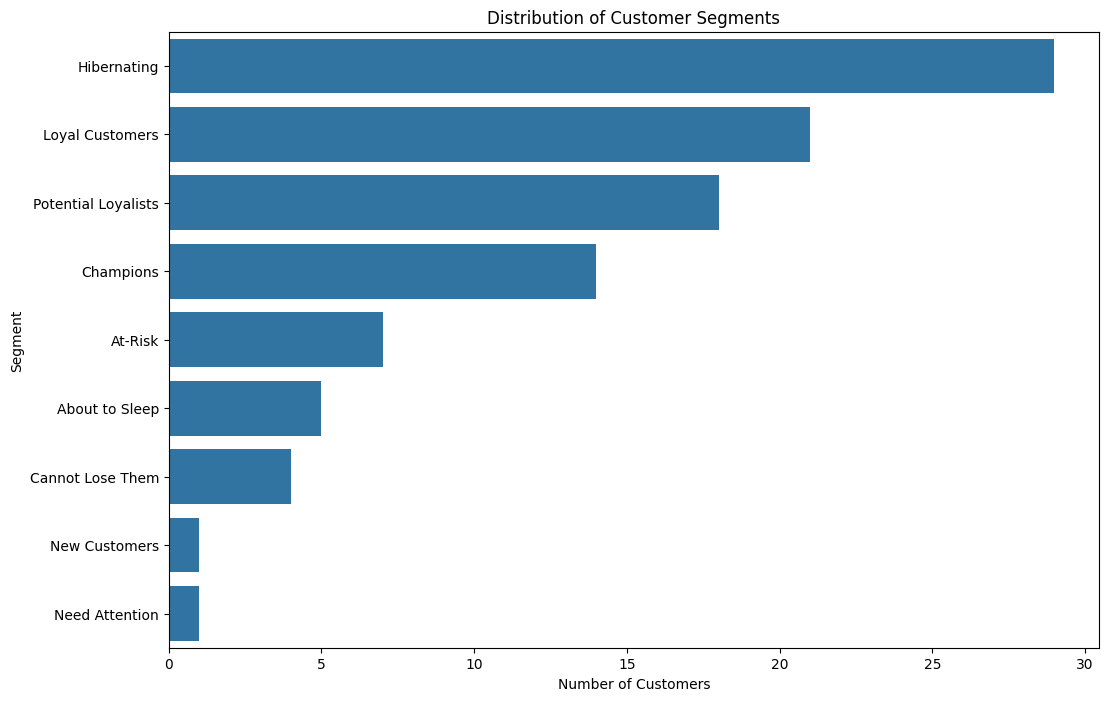

In [11]:
# Plot the distribution of customer segments
plt.figure(figsize=(12, 8))
sns.countplot(y='Segment', data=rfm_df, order=rfm_df['Segment'].value_counts().index)
plt.title('Distribution of Customer Segments')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')
plt.show()


##Summary of Customer Segment Distribution:

This distribution highlights the importance of focusing on retaining loyal customers while also implementing strategies to nurture new and at-risk customers.
The customer base is primarily concentrated in a few key segments, indicating distinct patterns of behavior.

- **Potential Loyalists:** This is one of a largest group. These are recent customers who have purchased more than once, or they are frequent, long-term customers.

- **Loyal Customers:** This is the other largest segment. These are customers who purchase frequently and have a high monetary value. They are the backbone of the business.
- **At-Risk:** This segment is also of a considerable size. These are customers who used to be frequent or high-spending customers but have not made a purchase in a while.
- **Hibernating:** This segment contains customers who have low recency, frequency, and monetary scores. They have not purchased in a long time and are at a high risk of churning.
- **Champions:** While a smaller segment, these are the best customers. They are recent, frequent, and high-spending.


##Recommendations:

- **Nurture Potential Loyalists:**

**Insight:** This is a large and promising group. They are showing signs of becoming highly valuable customers.

**What to do:** Engage them with personalized offers, loyalty programs, and exclusive content to encourage them to become "Champions" or "Loyal Customers."
- **Reward Loyal Customers:**

**Insight:** This is a strong and valuable segment. It's crucial to retain them.

**What to do:** Acknowledge their loyalty with exclusive rewards, early access to new products, and excellent customer service.
- **Re-engage At-Risk Customers:**

**Insight:** This segment represents a significant opportunity. These customers have shown value in the past but are slipping away.

**What to do:** Target them with personalized "we miss you" campaigns, special discounts, or surveys to understand why they haven't returned.
- **Wake Up Hibernating Customers:**

**Insight:** This segment is the most likely to churn. While they are a lower priority than "At-Risk" customers, they shouldn't be completely ignored.

**What to do:** Send them a final, attractive offer to try and win them back. If they don't respond, it may be best to focus resources on other segments.
- **Cherish Your Champions:**

**Insight:** These are your most valuable customers. They are your brand advocates.

**What to do:** Treat them like VIPs. Ask for reviews, feature them in testimonials, and provide them with the best possible experience to keep them happy.